Augmentation
============

This example shows how to apply data augmentation packages in conjunction with the `pymia.data` package. Besides transformations from the `pymia.data.augmentation` module, transformations from the Python packages [batchgenerators](https://github.com/MIC-DKFZ/batchgenerators) and [TorchIO](https://github.com/fepegar/torchio) are integrated.

<div class="alert alert-info">

Tip

This example is available as Jupyter notebook at `./examples/augmentation/basic.ipynb` and Python script at `./examples/augmentation/basic.py`.

</div>

<div class="alert alert-info">

Note

To be able to run this example:

- Get the example data by executing `./examples/example-data/pull_example_data.py`.
- Install matplotlib (`pip install matplotlib`).
- Install matplotlib (`pip install batchgenerators`).
- Install matplotlib (`pip install torchio`).

</div>

Import the required modules.

In [1]:
import os

import batchgenerators.transforms as bg_tfm
import matplotlib.pyplot as plt
import numpy as np
import torchio as tio

import pymia.data.transformation as tfm
import pymia.data.augmentation as augm
import pymia.data.definition as defs
import pymia.data.extraction as extr

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



We create the the access to the .h5 dataset by defining: (i) the indexing strategy (`indexing_strategy`)
that defines the chunks of data to be retrieved, and (ii) the information to be extracted (`extractor`).

In [2]:
hdf_file = '../example-data/example-dataset.h5'
indexing_strategy = extr.SliceIndexing()
extractor = extr.DataExtractor(categories=(defs.KEY_IMAGES, defs.KEY_LABELS))
dataset = extr.PymiaDatasource(hdf_file, indexing_strategy, extractor)

For reproducibility, set the seed and define a sample index for plotting.

In [3]:
seed = 42
np.random.seed(seed)
sample_idx = 55

To use batchgenerators and TorchIO, we create wrapper classes for simple integration into pymia. 

In [4]:
class BatchgeneratorsTransform(tfm.Transform):
    """Example wrapper for `batchgenerators <https://github.com/MIC-DKFZ/batchgenerators>`_ transformations."""

    def __init__(self, transforms, entries=(defs.KEY_IMAGES, defs.KEY_LABELS)) -> None:
        super().__init__()
        self.transforms = transforms
        self.entries = entries

    def __call__(self, sample: dict) -> dict:
        # unsqueeze samples to add a batch dimensions, as required by batchgenerators
        for entry in self.entries:
            if entry not in sample:
                if tfm.raise_error_if_entry_not_extracted:
                    raise ValueError(tfm.ENTRY_NOT_EXTRACTED_ERR_MSG.format(entry))
                continue

            np_entry = tfm.check_and_return(sample[entry], np.ndarray)
            sample[entry] = np.expand_dims(np_entry, 0)

        # apply batchgenerators transforms
        sample = self.transforms(**sample)  # todo: make loop over transforms

        # squeeze samples back to original format
        for entry in self.entries:
            np_entry = tfm.check_and_return(sample[entry], np.ndarray)
            sample[entry] = np_entry.squeeze(0)

        return sample


class TorchIOTransform(tfm.Transform):
    """Example wrapper for `TorchIO <https://github.com/fepegar/torchio>`_ transformations."""

    def __init__(self, transforms: list, entries=(defs.KEY_IMAGES, defs.KEY_LABELS)) -> None:
        super().__init__()
        self.transforms = transforms
        self.entries = entries

    def __call__(self, sample: dict) -> dict:
        # unsqueeze samples to be 4-D tensors, as required by TorchIO
        for entry in self.entries:
            if entry not in sample:
                if tfm.raise_error_if_entry_not_extracted:
                    raise ValueError(tfm.ENTRY_NOT_EXTRACTED_ERR_MSG.format(entry))
                continue

            np_entry = tfm.check_and_return(sample[entry], np.ndarray)
            sample[entry] = np.expand_dims(np_entry, -1)

        # apply TorchIO transforms
        for t in self.transforms:
            sample = t(sample)

        # squeeze samples back to original format
        for entry in self.entries:
            np_entry = tfm.check_and_return(sample[entry].numpy(), np.ndarray)
            sample[entry] = np_entry.squeeze(-1)

        return sample

We can now define the transformations to apply. For reference, we first do not apply any data augmentation. 

In [5]:
transforms_augmentation = []
transforms_before_augmentation = [tfm.Permute(permutation=(2, 0, 1)), ]  # to have the channel-dimension first
transforms_after_augmentation = [tfm.Squeeze(entries=(defs.KEY_LABELS,)), ]  # get rid of the channel-dimension for the labels
train_transforms = tfm.ComposeTransform(transforms_before_augmentation + transforms_augmentation + transforms_after_augmentation)
dataset.set_transform(train_transforms)
sample = dataset[sample_idx]

Let's us now use pymia to apply a random 90° rotation and a random mirroring.

In [6]:
transforms_augmentation = [augm.RandomRotation90(axes=(-2, -1)), augm.RandomMirror()]
train_transforms = tfm.ComposeTransform(
    transforms_before_augmentation + transforms_augmentation + transforms_after_augmentation)
dataset.set_transform(train_transforms)
sample_pymia = dataset[sample_idx]

/home/fabianbalsiger/PyCharmProjects/pymia/pymia/data/augmentation.py:232: RuntimeWarning: entry "images" has unequal in-plane dimensions (217, 181). Random 90 degree rotation might produce undesired results. Verify the output!
  RuntimeWarning)
/home/fabianbalsiger/PyCharmProjects/pymia/pymia/data/augmentation.py:232: RuntimeWarning: entry "labels" has unequal in-plane dimensions (217, 181). Random 90 degree rotation might produce undesired results. Verify the output!
  RuntimeWarning)


Let's us now use TorchIO to apply a random flip and a random affine transformation.

In [7]:
transforms_augmentation = [TorchIOTransform(
    [tio.RandomFlip(axes=('LR'), flip_probability=1.0, keys=(defs.KEY_IMAGES, defs.KEY_LABELS), seed=seed),
     tio.RandomAffine(scales=(0.9, 1.2), degrees=(10), isotropic=False, default_pad_value='otsu',
                      image_interpolation='NEAREST', keys=(defs.KEY_IMAGES, defs.KEY_LABELS), seed=seed),
     ])]
train_transforms = tfm.ComposeTransform(
    transforms_before_augmentation + transforms_augmentation + transforms_after_augmentation)
dataset.set_transform(train_transforms)
sample_torchio = dataset[sample_idx]

Let's us now use batchgenerators to apply a random 90° rotation and a random mirroring.

In [8]:
# todo
transforms_augmentation = [augm.RandomRotation90(axes=(-2, -1)), augm.RandomMirror()]
train_transforms = tfm.ComposeTransform(
    transforms_before_augmentation + transforms_augmentation + transforms_after_augmentation)
dataset.set_transform(train_transforms)
sample_batchgenerators = dataset[sample_idx]

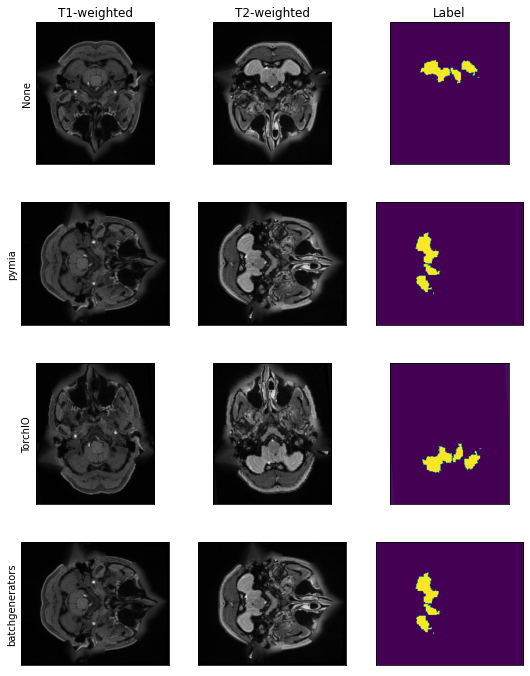

In [9]:
# prepare and format the plot
fig, axs = plt.subplots(4, 3, figsize=(9, 12))
axs[0, 0].set_title('T1-weighted')
axs[0, 1].set_title('T2-weighted')
axs[0, 2].set_title('Label')
axs[0, 0].set_ylabel('None')
axs[1, 0].set_ylabel('pymia')
axs[2, 0].set_ylabel('TorchIO')
axs[3, 0].set_ylabel('batchgenerators')
plt.setp(axs, xticks=[], yticks=[])

axs[0, 0].imshow(sample[defs.KEY_IMAGES][0], cmap='gray')
axs[0, 1].imshow(sample[defs.KEY_IMAGES][1], cmap='gray')
axs[0, 2].imshow(sample[defs.KEY_LABELS], cmap='viridis')
axs[1, 0].imshow(sample_pymia[defs.KEY_IMAGES][0], cmap='gray')
axs[1, 1].imshow(sample_pymia[defs.KEY_IMAGES][1], cmap='gray')
axs[1, 2].imshow(sample_pymia[defs.KEY_LABELS], cmap='viridis')
axs[2, 0].imshow(sample_torchio[defs.KEY_IMAGES][0], cmap='gray')
axs[2, 1].imshow(sample_torchio[defs.KEY_IMAGES][1], cmap='gray')
axs[2, 2].imshow(sample_torchio[defs.KEY_LABELS], cmap='viridis')
axs[3, 0].imshow(sample_batchgenerators[defs.KEY_IMAGES][0], cmap='gray')
axs[3, 1].imshow(sample_batchgenerators[defs.KEY_IMAGES][1], cmap='gray')
axs[3, 2].imshow(sample_batchgenerators[defs.KEY_LABELS], cmap='viridis')

Visually, we can clearly see the difference between the non-transformed and transformed images using different transformations and Python packages.